In [2]:
## necessary packages

using Distributions
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using Random
using SpecialFunctions # Matern functions
using MLBase         # cross-validation 
using Convex         # compute stacking weights
using MosekTools     # compute stacking weights
using RCall
include("./utils.jl")

sp_stacking_K_fold_V2 (generic function with 1 method)

In [3]:
# Set the parameters of the simulated data #
N_ls = [200, 300, 400, 500, 600, 700, 800, 900];
N_ho = 100;
seed = 1;
time_compar = Array{Float64, 3}(undef, length(N_ls), 3, 4);

In [4]:
## candidate values of hyperparameters for stacking ##
p = 2
deltasq_grid = fill(1.0, 4); 
phi_grid = [3, 14, 25, 36];
nu_grid = [0.5, 1, 1.5, 1.75];
## priors parameters ##
Priors = Dict("μβ" => fill(0.0, p), "inv_V_β" => Diagonal(ones(p) * 0.25), 
    "aσ" => 2.0, "bσ" => 2.0);
K_fold = 10;

In [ ]:
for sim_id in 1:4
    print("\n", "simulation: ", sim_id, "\n");
    if sim_id == 1
        global p = 2;
        global β = [1.0 2.0]; #regression coeff
        global σ2 = 1.0; ϕ = 7.0; ν = 1.0; τ2 = 1.0; # hyperparmeters in matern
    elseif sim_id == 2
        global p = 2
        global β = [1.0 2.0]; #regression coeff
        global σ2 = 1.0; ϕ = 20.0; ν = 0.5; τ2 = 0.3; # hyperparmeters in matern
    elseif sim_id == 3 
        global p = 2
        global β = [1.0 2.0]; #regression coeff
        global σ2 = 1.0; ϕ = 2.0; ν = 0.5; τ2 = 0.3; # hyperparmeters in matern
    else
        global p = 2;
        global β = [1.0 2.0]; #regression coeff
        global σ2 = 1.0; ϕ = 2.0; ν = 1.0; τ2 = 1.0; # hyperparmeters in matern
    end
    deltasq_grid = pick_deltasq(σ2, τ2; b = max(σ2, τ2), p_ls = [0.05, 0.35, 0.65, 0.95])
    for i in 1:length(N_ls)
        print("dataset: ", i, "\n")
        
        # generate simulation data #
        
        Random.seed!(i);
        N = N_ls[i];             # No. all positions
        ind_mod = 1:(N - N_ho);      # index of training observations
        coords = rand(2, N);         # random location over unit square (2 by N)
        X = vcat(fill(1.0, (1, N)), rand(Normal(), (1, N)));          # design matrix (p by N)
        D = pairwise(Euclidean(), coords, dims = 2);                  # distance matrix
        Cov = Symmetric(Maternlu.(UpperTriangular(D), 
                ν = ν, ϕ = ϕ, σ2 = σ2))                               # covariance matrix
        z = rand(MvNormal(Cov), 1);                                   # latent process
        y = (β * X)[1,:] + z[:,1] + sqrt(τ2) * rand(Normal(), N);     # response

        ## fit stacking ##
        # need to compile the function first to obtain precise time estimation #
        if sim_id == 1 & i == 1 
            time_compar[i, 1, sim_id] = @elapsed sp_stacking_K_fold_V2(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
                deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
                seed = seed, label = "LSE");
            time_compar[i, 2, sim_id] = @elapsed sp_stacking_K_fold_V2(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
                deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
                seed = seed, label = "LP");
        end

        time_compar[i, 1, sim_id] = @elapsed sp_stacking_K_fold_V2(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
            deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
            seed = seed, label = "LSE");

        time_compar[i, 2, sim_id] = @elapsed sp_stacking_K_fold_V2(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
            deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
            seed = seed, label = "LP");
        
        
        ## fit MCMC ##
        inv_V_beta = Priors["inv_V_β"]
        @rput X
        @rput y
        @rput ind_mod
        @rput coords
        @rput inv_V_beta
        
        R""" 

        library(spBayes)
        library(ggplot2)
        #library(geoR)

        X = t(X);
        coords = t(coords);

        n.samples <- 20000
        starting <- list("phi"=3/0.5, "sigma.sq"=1, "tau.sq"=1, "nu" = 0.5)
        tuning <- list("phi"=0.1, "sigma.sq"=0.1, "tau.sq"=0.1, "nu" = 0.1)
        priors.1 <- list("beta.Norm"=list(rep(0, ncol(X)), solve(inv_V_beta)),
                       "phi.Unif"=c(3, 36), "sigma.sq.IG"=c(2, 2),
                       "tau.sq.IG"=c(2, 2), "nu.unif" = c(0.25, 2))

        cov.model <- "matern"
        n.report <- 5000
        verbose <- TRUE
        m.1 <- spLM(y[ind_mod]~X[ind_mod, ]-1, coords=coords[ind_mod, ],
                  starting=starting,
                  tuning=tuning, priors=priors.1, cov.model=cov.model,
                  n.samples=n.samples, verbose=verbose, n.report=n.report)

        MCMC_t <- m.1$run.time[3]
        
        """
        @rget MCMC_t
        
        time_compar[i, 3, sim_id] = MCMC_t
        
    end  
end

In [6]:
@save "../results/time_comparV3_CPU64_Th8.jld" N_ls N_ho time_compar

In [16]:
## plot the comparision ##
@load "../results/time_comparV3_CPU64_Th8.jld" N_ls N_ho time_compar

3-element Vector{Symbol}:
 :N_ls
 :N_ho
 :time_compar

[1] 12


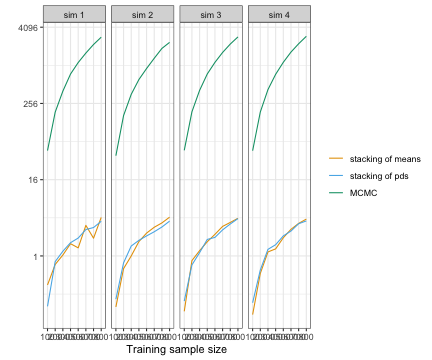

RObject{StrSxp}
[1] "../pics/time_compar_h_CPU64_Th8_V3.png"


In [25]:
@rput time_compar
@rput N_ls
@rput N_ho
R"""
library(ggplot2)
library(parallel)
print(detectCores())
time_dta <- data.frame(time = c(time_compar), 
                N_train = rep(paste(N_ls - N_ho), 3*4), 
                sim = rep(c(1, 2, 3, 4), each = length(N_ls)*3),
                type = rep(rep(c(1:3), each = length(N_ls)), 4))

sim_label = c("sim 1", "sim 2", "sim 3", "sim 4")              
time_dta$sim = factor(time_dta$sim, levels = 1:4, labels = sim_label)
type_label = c("stacking of means", "stacking of pds", "MCMC")              
time_dta$type = factor(time_dta$type, levels = 1:3, labels = type_label)                          


p_summary <- ggplot(time_dta, aes(x = N_train, y = time, color = label)) +
  geom_line(aes(x = N_train, y = time, group = type, color = type)) + 
  theme_bw() + xlab("Training sample size") + 
  facet_wrap(~ sim, nrow = 1, scales = "free_x", strip.position="top") +
  theme(legend.position="right", legend.title = element_blank(),
        legend.background = element_rect(fill = "transparent")) + ylab(" ") +
  scale_y_continuous(trans='log2') + 
  scale_colour_manual(values=c("#E69F00", "#56B4E9", "#009E73")) 
  
print(p_summary)

#plot(N_ls - 100, time_compar[, 1, 1])

ggsave(paste0("../pics/time_compar_h_CPU64_Th8_V3.png"), 
       plot = p_summary, 
       width = 10, height = 2.6, units = "in", dpi = 600)
       
"""

In [12]:
#Threads.nthreads()

In [8]:
time_compar

8×3×4 Array{Float64, 3}:
[:, :, 1] =
 0.348069  0.159962    46.111
 0.733042  0.813791   186.347
 1.0338    1.18601    400.41
 1.5617    1.61872    745.683
 1.34137   1.9163    1132.4
 3.03823   2.61137   1599.29
 1.90576   2.80994   2183.33
 4.06046   3.52213   2847.43

[:, :, 2] =
 0.156654  0.207638    38.296
 0.630262  0.776331   164.467
 0.999994  1.43504    356.654
 1.68651   1.76253    610.501
 2.29375   2.07032    911.657
 2.8379    2.40968   1323.23
 3.32148   2.86324   1892.69
 4.09438   3.54494   2358.71

[:, :, 3] =
 0.13347   0.193636    46.523
 0.844215  0.721305   188.957
 1.2113    1.12777    411.83
 1.6747    1.82305    747.113
 2.192     1.96215   1140.03
 2.9274    2.57992   1635.31
 3.38289   3.19643   2217.96
 3.93252   3.88661   2878.81

[:, :, 4] =
 0.118501  0.182248    45.901
 0.529485  0.599323   187.231
 1.15685   1.27111    424.172
 1.29296   1.50388    738.296
 1.93844   2.07241   1142.98
 2.63268   2.4734    1657.32
 3.26704   3.22985   2243.55
 3.81746   

In [20]:
describe(vcat(([time_compar[:,3,i] ./ time_compar[:,j, i] for i in 1:4, j in 1:1])...))

Summary Stats:
Length:         32
Missing Count:  0
Mean:           496.324966
Std. Deviation: 210.104087
Minimum:        132.476728
1st Quartile:   355.894667
Median:         471.876083
3rd Quartile:   599.609120
Maximum:        1145.643816
Type:           Float64


In [21]:
describe(vcat(([time_compar[:,3,i] ./ time_compar[:,j, i] for i in 1:4, j in 2:2])...))

Summary Stats:
Length:         32
Missing Count:  0
Mean:           483.340452
Std. Deviation: 199.028227
Minimum:        184.436298
1st Quartile:   306.368367
Median:         475.795156
3rd Quartile:   662.117152
Maximum:        823.700752
Type:           Float64


In [22]:
describe(vcat(([time_compar[:,3,i] ./ time_compar[:,j, i] for i in 1:4, j in 1:2])...))

Summary Stats:
Length:         64
Missing Count:  0
Mean:           489.832709
Std. Deviation: 203.115903
Minimum:        132.476728
1st Quartile:   339.395202
Median:         471.876083
3rd Quartile:   639.306221
Maximum:        1145.643816
Type:           Float64
